# Action-Based Expected Threat

# Setup

In [3]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from mplsoccer import Pitch
from itertools import combinations_with_replacement
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
notebook_directory = os.getcwd()
course_directory = ""

if os.name == "posix": 
    course_directory = notebook_directory.rsplit("/Notebooks")[0]
else:
    course_directory = notebook_directory.rsplit("\\Notebooks")[0]
os.chdir(course_directory)

# Data

In [21]:
df = pd.read_json(r"data\wyscout\poseesion_chains.json")
df.reset_index(drop=True, inplace=True)
df

In [7]:
df = pd.DataFrame()

for i in range(11):
    with open(f"data\possession_chains_England{i+1}.json") as file:
        data = json.load(file)    
    df = pd.concat([df, pd.DataFrame(data)])

df.reset_index(drop=True, inplace=True)
df

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,possesion_chain,possesion_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,...,0,1609,0.000000,0,51.45,0.68,32.55,19.04,34.68,14.96
1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,...,0,1609,0.000000,0,32.55,19.04,53.55,17.00,14.96,17.00
2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,...,0,1609,0.000000,0,53.55,17.00,36.75,14.28,17.00,19.72
3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,...,0,1609,0.000000,0,36.75,14.28,43.05,30.60,19.72,3.40
4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,...,0,1609,0.000000,0,43.05,30.60,75.60,25.84,3.40,8.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435129,43142,8,High pass,[{'id': 1801}],20620,"[{'y': 89, 'x': 53}, {'y': 72, 'x': 99}]",2500098,Pass,1633,2H,...,113381,1633,0.000000,0,55.65,26.52,103.95,14.96,7.48,19.04
435130,43143,8,Cross,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",14703,"[{'y': 72, 'x': 99}, {'y': 0, 'x': 0}]",2500098,Pass,1633,2H,...,113381,1633,0.000000,0,103.95,14.96,0.00,34.00,19.04,68.00
435131,43146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,...,113382,1633,0.038676,1,105.00,34.00,92.40,2.04,0.00,36.04
435132,43148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,...,113382,1633,0.038676,1,92.40,2.04,90.30,0.00,36.04,34.00


In [8]:
df[df["possesion_chain"] == 4]

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,possesion_chain,possesion_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
24,36,3,Free Kick,[{'id': 1801}],0,"[{'y': 44, 'x': 65}, {'y': 31, 'x': 65}]",2499719,Free Kick,1609,1H,...,4,1609,0.137573,1,68.25,4.08,68.25,12.92,38.08,46.92
25,37,8,Simple pass,[{'id': 1801}],49876,"[{'y': 31, 'x': 65}, {'y': 13, 'x': 90}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,68.25,12.92,94.50,25.16,46.92,59.16
26,38,1,Ground attacking duel,"[{'id': 502}, {'id': 703}, {'id': 1801}]",7868,"[{'y': 13, 'x': 90}, {'y': 14, 'x': 96}]",2499719,Duel,1609,1H,...,4,1609,0.137573,1,94.50,25.16,100.80,24.48,59.16,58.48
27,40,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",7868,"[{'y': 14, 'x': 96}, {'y': 3, 'x': 90}]",2499719,Duel,1609,1H,...,4,1609,0.137573,1,100.80,24.48,94.50,31.96,58.48,65.96
28,42,8,Simple pass,[{'id': 1801}],7868,"[{'y': 3, 'x': 90}, {'y': 13, 'x': 72}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,94.50,31.96,75.60,25.16,65.96,59.16
29,43,8,High pass,[{'id': 1801}],49876,"[{'y': 13, 'x': 72}, {'y': 86, 'x': 86}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,75.60,25.16,90.30,24.48,59.16,9.52
30,44,8,Simple pass,[{'id': 1801}],167145,"[{'y': 86, 'x': 86}, {'y': 71, 'x': 73}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,90.30,24.48,76.65,14.28,9.52,19.72
31,45,8,Cross,"[{'id': 301}, {'id': 402}, {'id': 801}, {'id':...",120339,"[{'y': 71, 'x': 73}, {'y': 41, 'x': 88}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,76.65,14.28,92.40,6.12,19.72,40.12
32,46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,...,4,1609,0.137573,1,92.40,6.12,105.00,0.00,40.12,34.00


# Prep the variables for models
- Models will be a non-linear combo of the start & end x coordinates & c (distance from the middle).
- The non-linear transformations of these are got via sampling with replacement for 1-3 combinations of the variables.

In [9]:
var = ["x0", "x1", "c0", "c1"]

inputs = []
inputs.extend(combinations_with_replacement(var, 1))
inputs.extend(combinations_with_replacement(var, 2))
inputs.extend(combinations_with_replacement(var, 3))

for i in inputs:
    if len(i) > 1:
        column = ""
        x = 1
        for c in i:
            column += c
            x = x*df[c]
        df[column] = x
        var.append(column)

df

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,x1x1x1,x1x1c0,x1x1c1,x1c0c0,x1c0c1,x1c1c1,c0c0c0,c0c0c1,c0c1c1,c1c1c1
0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,...,3.448681e+04,720.4617,20172.9276,15.05112,421.43136,11800.07808,0.314432,8.804096,246.514688,6902.411264
1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,...,1.535601e+05,54599.1516,48749.2425,19413.03168,17333.06400,15475.95000,6902.411264,6162.867200,5502.560000,4913.000000
2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,...,4.963317e+04,22959.5625,19286.0325,10620.75000,8921.43000,7494.00120,4913.000000,4126.920000,3466.612800,2911.954752
3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,...,7.978467e+04,26465.1597,56711.0565,8778.68712,18811.47240,40310.29800,2911.954752,6239.903040,13371.220800,28652.616000
4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,...,4.320812e+05,174890.0160,147684.9024,70788.81600,59777.22240,50478.54336,28652.616000,24195.542400,20431.791360,17253.512704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435129,43142,8,High pass,[{'id': 1801}],20620,"[{'y': 89, 'x': 53}, {'y': 72, 'x': 99}]",2500098,Pass,1633,2H,...,1.123242e+06,286564.5783,161651.8134,73109.11608,41241.03984,23264.17632,18651.791808,10521.523584,5935.218432,3348.071936
435130,43143,8,Cross,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",14703,"[{'y': 72, 'x': 99}, {'y': 0, 'x': 0}]",2500098,Pass,1633,2H,...,0.000000e+00,0.0000,0.0000,0.00000,0.00000,0.00000,3348.071936,7609.254400,17293.760000,39304.000000
435131,43146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,...,7.888890e+05,290283.8400,17417.0304,106814.40000,6408.86400,384.53184,39304.000000,2358.240000,141.494400,8.489664
435132,43148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,...,7.363143e+05,16634.3436,0.0000,375.79248,0.00000,0.00000,8.489664,0.000000,0.000000,0.000000


In [15]:
df[df["possesion_chain"] == 4]

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,x1x1x1,x1x1c0,x1x1c1,x1c0c0,x1c0c1,x1c1c1,c0c0c0,c0c0c1,c0c1c1,c1c1c1
24,36,3,Free Kick,[{'id': 1801}],0,"[{'y': 44, 'x': 65}, {'y': 31, 'x': 65}]",2499719,Free Kick,1609,1H,...,3.179128e+05,19004.8950,60182.1675,1136.11680,3597.70320,11392.72680,67.917312,215.071488,681.059712,2156.689088
25,37,8,Simple pass,[{'id': 1801}],49876,"[{'y': 31, 'x': 65}, {'y': 13, 'x': 90}]",2499719,Pass,1609,1H,...,8.439086e+05,115378.8300,224685.0900,15774.54480,30718.85040,59820.91920,2156.689088,4199.868224,8178.690752,15926.924096
26,38,1,Ground attacking duel,"[{'id': 502}, {'id': 703}, {'id': 1801}]",7868,"[{'y': 13, 'x': 90}, {'y': 14, 'x': 96}]",2499719,Duel,1609,1H,...,1.024193e+06,255641.7024,248732.4672,63808.98048,62084.41344,60406.45632,15926.924096,15496.466688,15077.643264,14670.139392
27,40,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",7868,"[{'y': 14, 'x': 96}, {'y': 3, 'x': 90}]",2499719,Duel,1609,1H,...,8.439086e+05,218612.5200,285410.7900,56631.05280,73934.98560,96526.23120,14670.139392,19152.681984,25004.890368,32645.273536
28,42,8,Simple pass,[{'id': 1801}],7868,"[{'y': 3, 'x': 90}, {'y': 13, 'x': 72}]",2499719,Pass,1609,1H,...,4.320812e+05,182662.9056,143798.4576,77220.98496,60790.98816,47856.73536,32645.273536,25699.470656,20231.498176,15926.924096
29,43,8,High pass,[{'id': 1801}],49876,"[{'y': 13, 'x': 72}, {'y': 86, 'x': 86}]",2499719,Pass,1609,1H,...,7.363143e+05,205156.9044,199612.1232,57162.21168,55617.28704,54114.11712,15926.924096,15496.466688,15077.643264,14670.139392
30,44,8,Simple pass,[{'id': 1801}],167145,"[{'y': 86, 'x': 86}, {'y': 71, 'x': 73}]",2499719,Pass,1609,1H,...,4.503358e+05,143825.4468,83898.1773,45934.07616,26794.87776,15630.34536,14670.139392,8557.581312,4991.922432,2911.954752
31,45,8,Cross,"[{'id': 301}, {'id': 402}, {'id': 801}, {'id':...",120339,"[{'y': 71, 'x': 73}, {'y': 41, 'x': 88}]",2499719,Pass,1609,1H,...,7.888890e+05,121919.2128,52251.0912,18842.06016,8075.16864,3460.78656,2911.954752,1247.980608,534.848832,229.220928
32,46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,...,1.157625e+06,67473.0000,0.0000,3932.71200,0.00000,0.00000,229.220928,0.000000,0.000000,0.000000


# Calculate action based xT for passes
1. Predict the outcome of a shot using XGBoost.

In [21]:
passes = df.loc[df["eventName"] == "Pass"].copy()

X = passes[var].values
y = passes["shot_end"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123, stratify=y)

xgb_classifier = xgb.XGBClassifier(n_estimators=100,  max_depth=4,  min_child_weight=10, random_state=123)
scores = cross_val_score(estimator=xgb_classifier, X=X_train, y=y_train, cv=10, n_jobs=-1, verbose=-1)
xgb_classifier.fit(X_train, y_train)

print(np.mean(scores), np.std(scores))
print(xgb_classifier.score(X_train, y_train))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  4.1min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.2min finished


0.920383290224084 0.00017419989879516136
0.9206795316351373


In [22]:
y_pred_proba = xgb_classifier.predict_proba(X_test)
print(xgb_classifier.score(X_test, y_test))

0.9204607601859448


In [23]:
y_pred_proba = xgb_classifier.predict_proba(X)[::,1]

passes["shot_prob"] = y_pred_proba
shot_ended  = passes.loc[passes["shot_end"] == 1]

X2 = shot_ended[var].values
y2 = shot_ended["xG"].values

lr = LinearRegression()
lr.fit(X2, y2)
y_pred = lr.predict(X)

passes["xG_pred"] = y_pred
passes["xT"] = passes["xG_pred"] * passes["shot_prob"]
passes[["xG_pred", "shot_prob", "xT"]].head(5)

,xG_pred,shot_prob,xT
0,0.121099,0.035804,0.004336
1,0.108244,0.042915,0.004645
2,0.121571,0.044241,0.005378
3,0.118808,0.031893,0.003789
4,0.116028,0.046093,0.005348


# Plot Pass Values

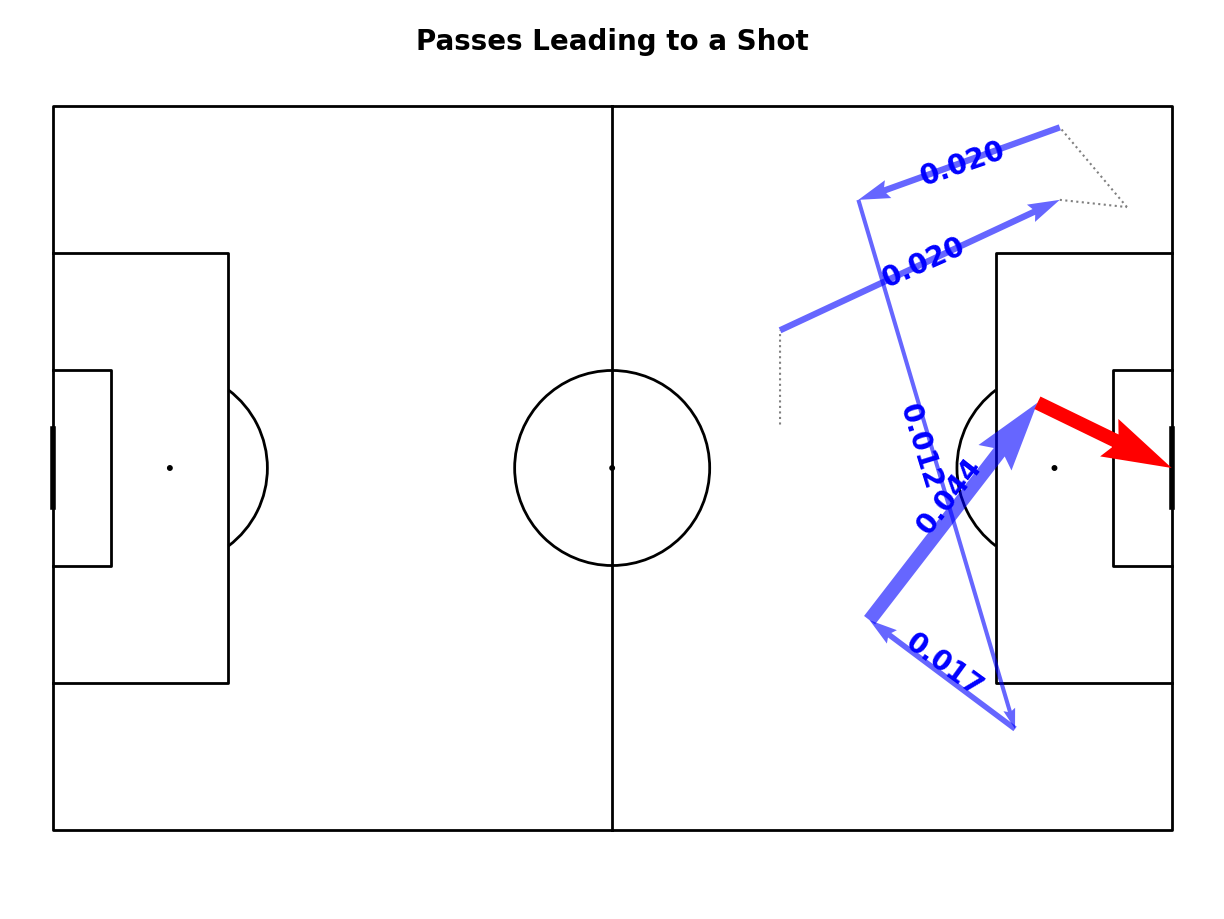

In [26]:
example_chain = df.loc[df["possesion_chain"] == 4]
passes_in = passes.loc[df["possesion_chain"] == 4]
max_value = passes_in["xT"].max()
not_passes = example_chain.loc[example_chain["eventName"] != "Pass"].iloc[:-1]
shot = example_chain.iloc[-1]

pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

for i, row in passes_in.iterrows():
    value = row["xT"]
    line_width = (value/max_value * 10)
    angle = np.arctan((row.y1-row.y0) / (row.x1-row.x0))*180/np.pi
    pitch.arrows(row.x0, row.y0, row.x1, row.y1, alpha=0.6, width=line_width, zorder=2, color="blue", ax=ax["pitch"])
    ax["pitch"].text((row.x0+row.x1-8) / 2, (row.y0+row.y1-4) / 2, str(value)[:5], fontweight="bold",  color="blue", zorder=4, fontsize=20, rotation = int(angle))

pitch.arrows(shot.x0, shot.y0, shot.x1, shot.y1, width=line_width, color="red", ax=ax["pitch"], zorder=3)
pitch.lines(not_passes.x0, not_passes.y0, not_passes.x1, not_passes.y1, color="grey", lw=1.5, ls="dotted", ax=ax["pitch"])

fig.suptitle("Passes Leading to a Shot", fontweight="bold", fontsize=20);

# Players with the highest action based xT

In [36]:
players_df = pd.read_json("data\wyscout\players.json", encoding="unicode_escape")
players_df.rename(columns={"wyId" : "playerId"}, inplace=True)
players_df["role"] = players_df.apply(lambda x: x.role["name"], axis=1)
to_merge = players_df[["playerId", "shortName", "role"]]
to_merge

,playerId,shortName,role
0,32777,H. Tekin,Goalkeeper
1,393228,M. Sarr,Defender
2,393230,O. Mandanda,Goalkeeper
3,32793,A. N'Diaye,Midfielder
4,393247,I. Konaté,Defender
...,...,...,...
3598,120839,A. Maâloul,Defender
3599,114736,C. Cáceda,Goalkeeper
3600,114908,M. Araujo,Defender
3601,285583,A. Tagnaouti,Goalkeeper


In [37]:
summary = passes[["playerId", "xT"]].groupby("playerId").sum().reset_index()
summary = summary.merge(to_merge, on="playerId", how="left")
summary

,playerId,xT,shortName,role
0,0,0.028406,NaN,NaN
1,36,5.090994,T. Alderweireld,Defender
2,38,1.698282,D. Blind,Defender
3,48,12.527994,J. Vertonghen,Defender
4,54,24.822709,C. Eriksen,Midfielder
...,...,...,...,...
509,448708,0.059641,H. Barnes,Midfielder
510,450826,0.209381,C. Hudson-Odoi,Midfielder
511,486252,1.522150,A. Wan-Bissaka,Defender
512,531655,0.100338,L. Lumeka,Forward


In [38]:
minutes_per_game_df = pd.read_json("data\wyscout\minutes_played_per_game_England.json")
minutes = minutes_per_game_df.groupby("playerId")[["minutesPlayed"]].sum().reset_index()
summary = minutes.merge(summary, how="left", on="playerId")
summary = summary.fillna(0)
summary

,playerId,minutesPlayed,xT,shortName,role
0,36,1238,5.090994,T. Alderweireld,Defender
1,38,382,1.698282,D. Blind,Defender
2,48,3343,12.527994,J. Vertonghen,Defender
3,54,3348,24.822709,C. Eriksen,Midfielder
4,56,266,0.901909,D. Klaassen,Midfielder
...,...,...,...,...,...
510,448708,21,0.059641,H. Barnes,Midfielder
511,450826,35,0.209381,C. Hudson-Odoi,Midfielder
512,486252,649,1.522150,A. Wan-Bissaka,Defender
513,531655,28,0.100338,L. Lumeka,Forward


In [39]:
summary_over_400_minutes = summary.loc[summary["minutesPlayed"] > 400].copy()
summary_over_400_minutes["xT_per_90"] = summary_over_400_minutes["xT"] * 90 / summary_over_400_minutes["minutesPlayed"]
summary_over_400_minutes 

,playerId,minutesPlayed,xT,shortName,role,xT_per_90
0,36,1238,5.090994,T. Alderweireld,Defender,0.370105
2,48,3343,12.527994,J. Vertonghen,Defender,0.337278
3,54,3348,24.822709,C. Eriksen,Midfielder,0.667277
5,74,1514,5.794635,R. Klavan,Defender,0.344463
6,93,2942,8.596886,J. Guðmunds­son,Midfielder,0.262991
...,...,...,...,...,...,...
491,397178,1904,7.826241,M. Rashford,Forward,0.369938
500,419784,405,0.939278,H. Choudhury,Midfielder,0.208728
502,434159,561,1.436282,S. Field,Midfielder,0.230420
508,447812,499,1.050954,T. Edwards,Defender,0.189551


In [40]:
possesion_df = pd.read_json("data\wyscout\player_possesion_England.json")
summary_over_400_minutes = summary_over_400_minutes.merge(possesion_df, how="left", on="playerId")
summary_over_400_minutes["xT_adjusted_per_90"] = (summary_over_400_minutes["xT"] / summary_over_400_minutes["possesion"])  * 90 / summary_over_400_minutes["minutesPlayed"]
summary_over_400_minutes

,playerId,minutesPlayed,xT,shortName,role,xT_per_90,possesion,xT_adjusted_per_90
0,36,1238,5.090994,T. Alderweireld,Defender,0.370105,0.597434,0.619490
1,48,3343,12.527994,J. Vertonghen,Defender,0.337278,0.597295,0.564675
2,54,3348,24.822709,C. Eriksen,Midfielder,0.667277,0.606674,1.099894
3,74,1514,5.794635,R. Klavan,Defender,0.344463,0.592251,0.581617
4,93,2942,8.596886,J. Guðmunds­son,Midfielder,0.262991,0.438288,0.600042
...,...,...,...,...,...,...,...,...
392,397178,1904,7.826241,M. Rashford,Forward,0.369938,0.552620,0.669426
393,419784,405,0.939278,H. Choudhury,Midfielder,0.208728,0.520446,0.401057
394,434159,561,1.436282,S. Field,Midfielder,0.230420,0.402257,0.572816
395,447812,499,1.050954,T. Edwards,Defender,0.189551,0.420026,0.451284


In [41]:
summary_over_400_minutes[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(5)

,shortName,xT_adjusted_per_90
22,M. Özil,1.517753
27,Fàbregas,1.426529
250,E. Hazard,1.373377
30,A. Sánchez,1.346957
117,David Silva,1.310881


# Challenge
1. Do the same analysis but for the Indian Super League 2021/22 season.